In [1]:
import numpy as np

In [2]:
from scipy import integrate as inte
import pandas as pd
import sys
import matplotlib.pyplot as plt
from bisect import bisect

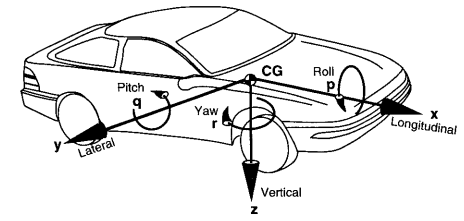

Variables y ktes

In [3]:
g=9.82 #gravity[m/s^2]

ISA (Atmósfera estandar)

In [4]:
def rho(hSNM):
    a=-6.5/1000 #ISA gradient [K/m]
    T0=288.15 #ISA Base temperature
    R=287 # Ideal gas kte [m^2/(s^2-K)]
    h0=0 #ISA Base heigh
    rho0=1.223 #ISA Base density
    T=T0+a*(hSNM-h0)
    rho_h=rho0*(T/T0)**((-g/(a*R))-1)
    return rho_h

Masa equivalente

In [5]:
mKart=152#Masa del kart [kg]
mt=1.43
md=1.2
meq=mKart+mt+md
hSNM=2600

dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
Nc=11/39 #Relación de transmisión
dps=[7,11,13]
dpls=[33,39,51]
eficiencia=0.95 #Eficiencia de transmisión
rLl=0.139 #Radio geométrico llantas traseras [m]
r_et=0.98*rLl #Radio efectivo llantas traseras
cg=[-0.2231,0.4875,0.07478] #Centro de gravedad [-x,y,z] [m]
l=1.0063 #Batalla [m]
deltat=0.001 #[s]
theta=0 #Ángulo de inclinación de la pista
FrCoef=0.85 #Friction coefficient

Ncs=[]
for n in dps:
    for i in dpls:
        Ncs=np.append(Ncs,n/i)

Fuerzas

In [6]:
def peso(m):
    w=g*m
    return w

def FInclinacion(m,theta):
    Fincl=peso(m)*np.sin(theta)
    return Fincl

def Drag(v):
    d_del=0.975 #Distancia entre llantas delanteras [m]
    h=0.88 #Altura con el piloto sentado
    af=(d_del*h)/2 #Área frontal del kart
    cd=0.89 #kart Drag coeficient
    r_et=0.98*rLl
    #vomega=omega*r_et
    D=(1/2)*rho(hSNM)*af*cd*np.math.fabs(v)**2
    return D

#Se modela la rodadura como mRod*a+kteRod
def Rodadura(m,v,theta):
    A=peso(m)*(cg[0]/l)
    B=peso(m)*(1/g*(cg[2]/l)) 
    fr=0.01*(1+(v/100))# Factor de rodadura velocidad en [km/h]
    C=fr*np.cos(theta) 
    mRod=B*C
    kteRod=A*C
    return [mRod,kteRod]

def FTraccion(Te,Nc):
    ef=eficiencia
    Ftor=Te*Nc*ef/r_et
    return Ftor

def Ffreno(coef,m,v,theta):
    A=peso(m)*(cg[0]/l)
    B=peso(m)*(1/g*(cg[2]/l)) 
    C=coef*np.cos(theta) 
    mFr=B*C
    kteFr=A*C
    return [mFr,kteFr]

def Torq (omega):
    P=3.037*((-0.00000004564538677*(omega**3))+(0.0001056995459*(omega**2))+(1.53209191*omega)-1.895523696)
    if 0<=omega<=30:
        Torque= 40
    else:
        Torque=P/(omega*2*np.pi/60)
    return Torque

Arranque:

In [7]:
def dvdtA(v,t0,Nc,m):
    x,vel=v
    #Constantes e inputs funciones
    omega=(vel/(r_et*eficiencia))*(60/(2*np.pi))*Nc #5000 
    mRod=Rodadura(m,vel,theta)[0] #Masa del modelo de rodadura
    kRod=Rodadura(m,vel,theta)[1] #Constante del modelo de Rodadura
    #Torque en el eje
    Te=Torq(omega)
    #Función a solucionar
    acel=(1/m)*(FTraccion(Te,Nc)-kRod-Drag(vel)-FInclinacion(m,theta))
    return [vel,acel]

def solutionStart(t0,condIniciales,variacion,Nc,m):
    t=np.arange(t0,t0+3,deltat)
    sol=inte.odeint(dvdtA,condIniciales,t,args=(Nc,m))
    if sol[-1,1]-sol[-2,1]<=variacion:
        return sol
    else:
        return np.concatenate((sol,solutionStart(t[-1],[sol[-1,0],sol[-1,1]],variacion,Nc,m)),axis=0)

Frenado:

In [8]:
def dvdtFr(v,t0):
    x,vel=v
    mFr=Ffreno(FrCoef,meq,vel,theta)[0] #Masa del modelo de rodadura
    kFr=Ffreno(FrCoef,meq,vel,theta)[1] #Constante del modelo de Rodadura
    
    #Función a solucionar
    acel=(1/(meq+mFr))*(kFr-Drag(vel)-FInclinacion(meq,theta))
    return [vel,acel]

def solutionBreak(t0,condIniciales):
    t=np.arange(t0,t0+2,deltat)
    sol=inte.odeint(dvdtFr,condIniciales,t)
    if sol[-1,1]<=0:
        return sol
    else:
        return np.concatenate((sol,solutionBreak(t[-1],[sol[-1,0],sol[-1,1]])),axis=0)

Plot de posición vs velocidad

Informe:
En este taller se pretende desarrollar un modelo para simular el tiempo de llegada a velocidad pico de un kart eléctrico,específicamente se realizó un simulador para encontrar las curvas de velocidad vs tiempo para el kart al variar su relación de transmisión.
Para la solución de la ecuación diferencial se utilizó el método de solución RK45. A continuación se presentan los gráficosobtenidos mediante el simulador para las relaciones de transmisión de [ 0.21212121  0.17948718  0.1372549   0.33333333  0.28205128  0.21568627
  0.39393939  0.33333333  0.25490196] .
Es posible observar que el punto de mejor operación ocurre cuando la relación de transmisión es de 0.39, puesto que en este caso, la velocidad pico es de 25.3 $m/s$ y el tiempo que tarda el vehiculo en arrancar, alcanzar su velocidad pico y frenarhasta cero es de 70 s, también se observa que el punto de peor operación es cuando se tiene una relación de transmisión de0.14, puesto que en este caso, la velocidad pico es la 

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 73001000 but corresponding boolean dimension is 73001


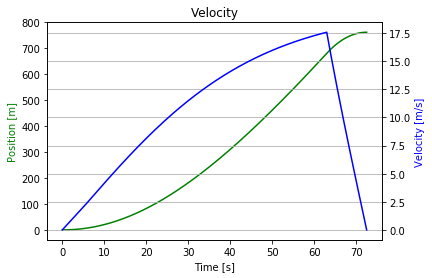

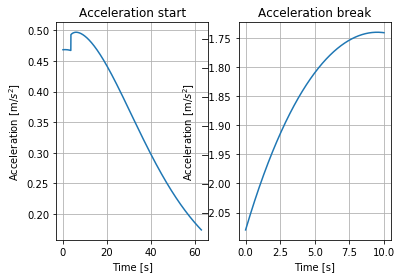

Relación de Transmisión = 0.212121212121 ;Masa = 154.63 kg ;Velocidad pico = 17.5789907022 m/s ;tiempo total =  72.515  s


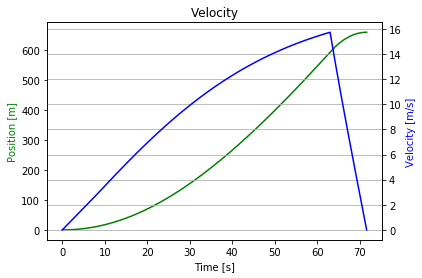

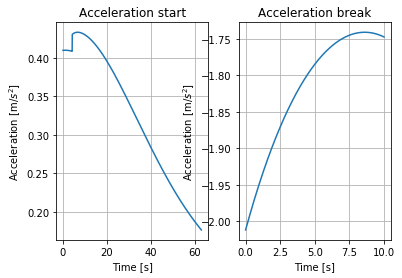

Relación de Transmisión = 0.179487179487 ;Masa = 154.63 kg ;Velocidad pico = 15.7282177574 m/s ;tiempo total =  71.61  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 74001000 but corresponding boolean dimension is 74001


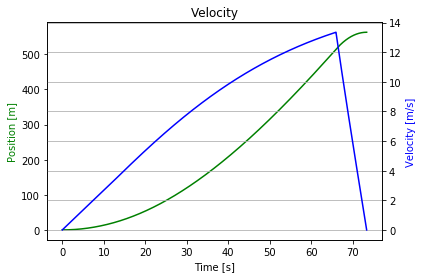

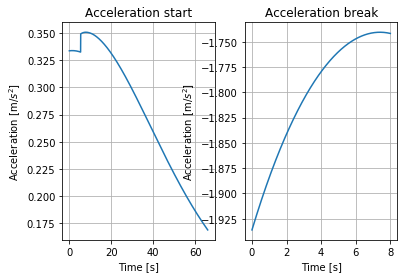

Relación de Transmisión = 0.137254901961 ;Masa = 154.63 kg ;Velocidad pico = 13.3456564746 m/s ;tiempo total =  73.402  s


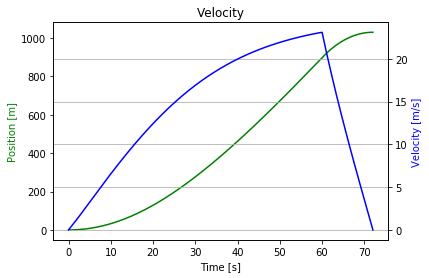

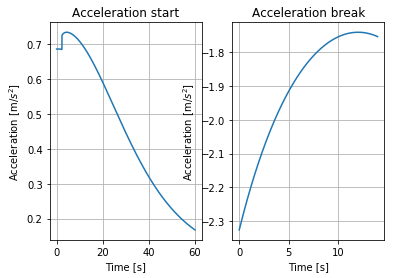

Relación de Transmisión = 0.333333333333 ;Masa = 154.63 kg ;Velocidad pico = 23.1036940282 m/s ;tiempo total =  72.034  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 72001000 but corresponding boolean dimension is 72001


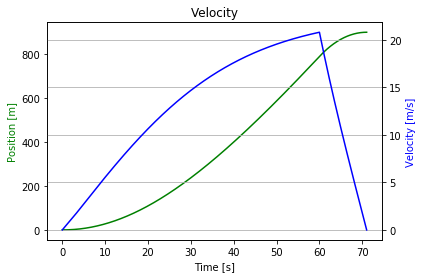

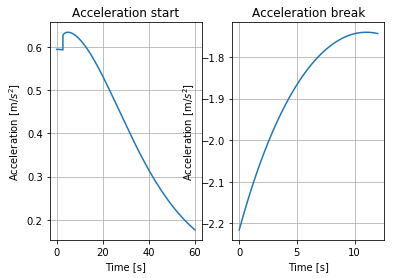

Relación de Transmisión = 0.282051282051 ;Masa = 154.63 kg ;Velocidad pico = 20.8104236954 m/s ;tiempo total =  71.023  s


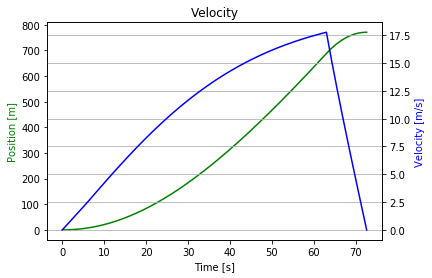

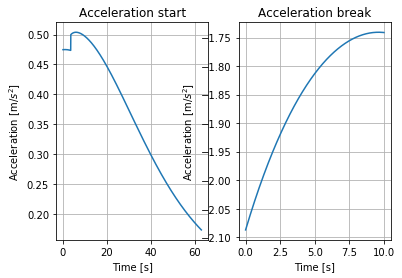

Relación de Transmisión = 0.21568627451 ;Masa = 154.63 kg ;Velocidad pico = 17.771791374 m/s ;tiempo total =  72.608  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71001000 but corresponding boolean dimension is 71001


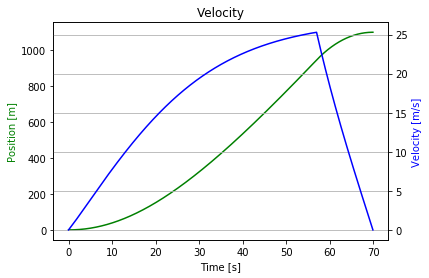

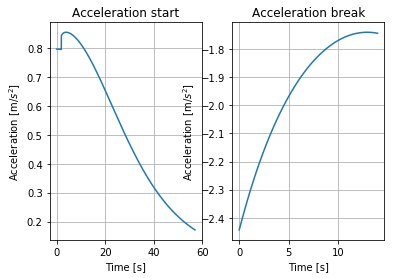

Relación de Transmisión = 0.393939393939 ;Masa = 154.63 kg ;Velocidad pico = 25.2990208987 m/s ;tiempo total =  69.955  s


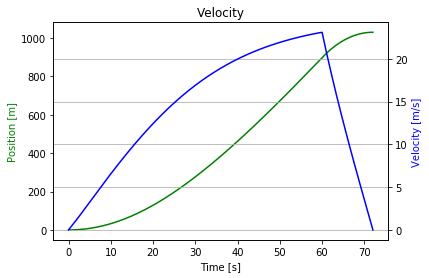

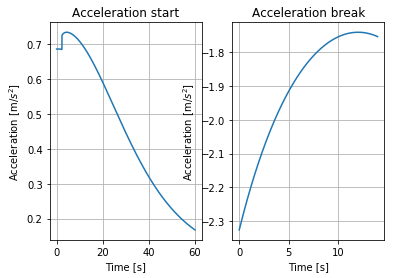

Relación de Transmisión = 0.333333333333 ;Masa = 154.63 kg ;Velocidad pico = 23.1036940282 m/s ;tiempo total =  72.034  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 75001000 but corresponding boolean dimension is 75001


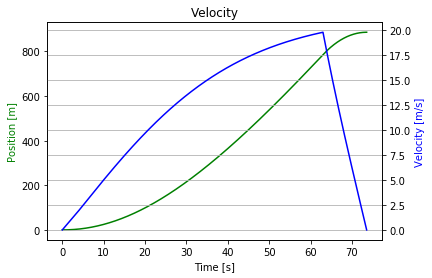

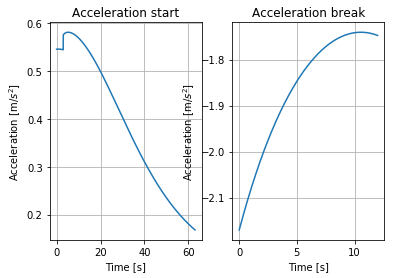

Relación de Transmisión = 0.254901960784 ;Masa = 154.63 kg ;Velocidad pico = 19.787951599 m/s ;tiempo total =  73.556  s


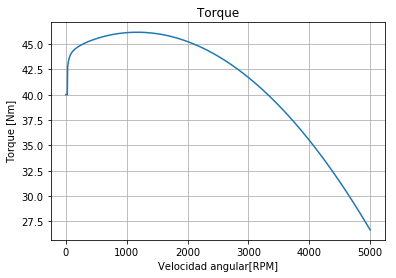

Torque máximo alcanzado = 46.1599720745 Nm


In [11]:
print('Informe:')
print('En este taller se pretende desarrollar un modelo para simular el tiempo de llegada a velocidad pico de un kart eléctrico,'
      'específicamente se realizó un simulador para encontrar las curvas de velocidad vs tiempo para el kart al variar su relación de transmisión.')
print('Para la solución de la ecuación diferencial se utilizó el método de solución RK45. A continuación se presentan los gráficos'
     'obtenidos mediante el simulador para las relaciones de transmisión de',Ncs,'.')
print('Es posible observar que el punto de mejor operación ocurre cuando la relación de transmisión es de 0.39, puesto que en este '
     'caso, la velocidad pico es de 25.3 $m/s$ y el tiempo que tarda el vehiculo en arrancar, alcanzar su velocidad pico y frenar'
     'hasta cero es de 70 s, también se observa que el punto de peor operación es cuando se tiene una relación de transmisión de'
     '0.14, puesto que en este caso, la velocidad pico es la menor (13.3 $m/s$) y así mismo, el tiempo total es 3s mayor')
print('Finalmente, se pueden observar los valores de la aceleración al arranque y al freno en cada caso, esto con el fin de comprobar'
     'que efectivamente son reales las curvas de velocidad propuestas, además de la curva del torque del motor en función de la velocidad angular '
     'del eje')
m=meq
for n in Ncs:
    t_inA=0
    x_0A=0
    v_0A=0
    solA=solutionStart(t_inA,[x_0A,v_0A],0.0001,n,m)

    t_inFr=0
    v_0Fr=solA[-1,1]
    x_0Fr=solA[-1,0]
    solFr=solutionBreak(t_inFr,[x_0Fr,v_0Fr])#Solución de la ecuación
    sol=np.concatenate((solA,solFr))
    
    #Acceleration
    acelA=[]
    for v in solA[:,1]:
        omega=(v/(r_et*eficiencia))*(60/(2*np.pi))*Nc #5000
        mRod=Rodadura(meq,v,theta)[0] #Masa del modelo de rodadura
        kRod=Rodadura(meq,v,theta)[1] #Constante del modelo de Rodadura
        Te=Torq(omega) 
        acelA=np.append(acelA,
                        (1/(meq+4*mRod))*(FTraccion(Te,n)-4*kRod-Drag(v)-FInclinacion(meq,theta)))
    acelFr=[]
    for v in solFr[:,1]:
        mFr=Ffreno(FrCoef,meq,v,0)[0] #Masa del modelo de rodadura
        kFr=Ffreno(FrCoef,meq,v,theta)[1] #Constante del modelo de Rodadura
        #Función a solucionar
        acelFr=np.append(acelFr,
                         (1/(meq+mFr))*(kFr-Drag(v)-FInclinacion(meq,theta)))    
    #DataFrame
    data=pd.DataFrame=({'Time':np.arange(0,len(sol[:,0]),deltat),
                'Position':sol[:,0],
                'Velocity':sol[:,1]})
    #Plot
    t=data['Time'][data['Velocity']>=0]
    pltPosition=data['Position'][data['Velocity']>=0]
    pltVelocity=data['Velocity'][data['Velocity']>=0]

    #Velocity and position
    fig,ax1=plt.subplots()
    ax2=ax1.twinx()
    ax1.plot(t,pltPosition,'g-')
    ax2.plot(t,pltVelocity,'b-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Position [m]', color='g')
    ax2.set_ylabel('Velocity [m/s]', color='b')
    plt.grid()
    plt.title('Velocity')
    plt.show()
    #Acceleration
    plt.subplot(1,2,1)
    plt.plot(t[:len(acelA)],acelA)
    plt.grid()
    plt.title('Acceleration start')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/$s^2$]')
    plt.subplot(1,2,2)
    plt.plot(t[:len(acelFr)],acelFr)
    plt.grid()
    plt.title('Acceleration break')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/$s^2$]')
    plt.show()
    print('Relación de Transmisión =',n,';Masa =',m,'kg ;Velocidad pico =',solA[-1,1],'m/s ;tiempo total = ',t[-1],' s')
    #Torque
omega=np.linspace(0,5000,1000)
T=[]
for w in omega:
    T=np.append(T,Torq(w))
plt.plot(omega,T)
plt.grid()
plt.title('Torque')
plt.xlabel('Velocidad angular[RPM]')
plt.ylabel('Torque [Nm]')
plt.show()
print('Torque máximo alcanzado =',max(T),'Nm')